<a href="https://colab.research.google.com/github/GUmarEla/Image_Processing/blob/main/01_ImageEnhancement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Image enhancement algos

*   histogram_equalization
*   contrast_image
*   retinex

### Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

### Import And read image

In [ ]:
# Import necessary libraries
import requests

# Define the image URL
url = 'https://i.sstatic.net/Ips0H.jpg'
# url = "https://t4.ftcdn.net/jpg/02/74/58/77/360_F_274587784_kLmAWaNye3u8VEshJJntfor9CNwwMgBx.jpg"
# url = 'https://www.researchgate.net/profile/Felix-Calderon/publication/220887121/figure/fig1/AS:341726976856065@1458485468169/Denoising-experiment-for-Cameraman-image-with-gaussian-se-20-and-Salt-and-Pepper_Q320.jpg'

# Download the image
response = requests.get(url)
img_data1 = response.content

# Convert image data to a NumPy array
img_array1 = np.frombuffer(img_data1, np.uint8)

# Decode the images
image = cv2.imdecode(img_array1, cv2.IMREAD_COLOR)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_color = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

### Histogram Equalization

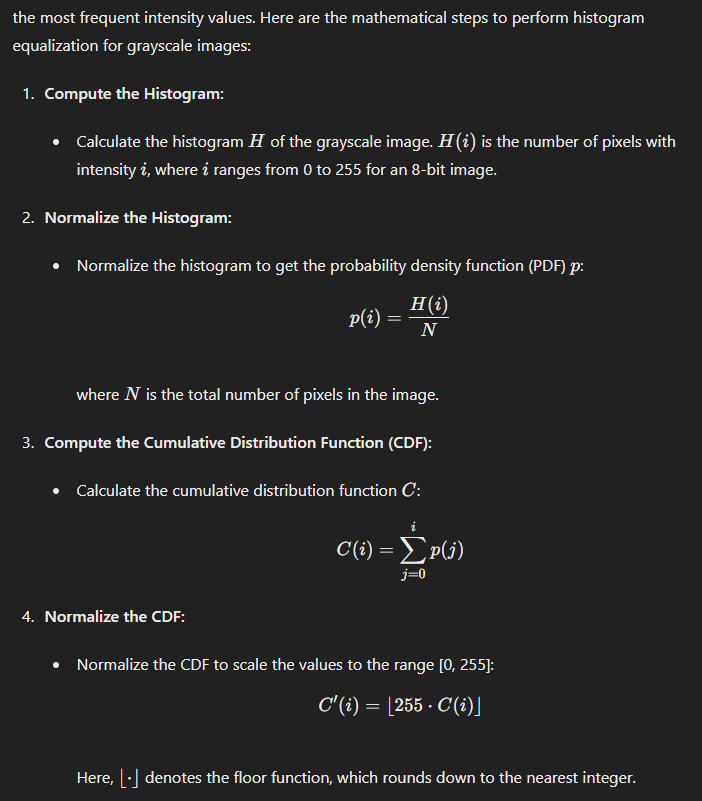

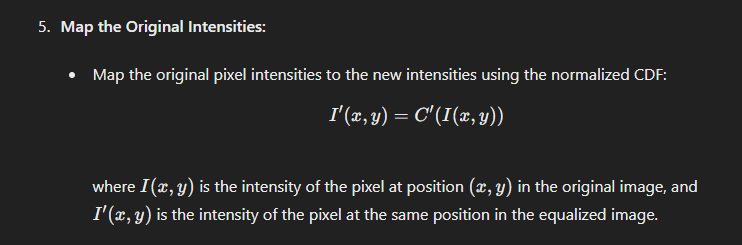

Applying histogram equalization to RGB method is not that differnet if you underdstand the method above.

In the case of color images (RGB)

1.   Convert from RGB HSV
2.   apply the histogram equalization method that you use the gray image in the value (V) channel
3.   Convert image back from HSV to RGB


more insights:
https://www.youtube.com/watch?v=Yd6QISby8kk&t=321s

the video (link above) explains to great extent the method

In [ ]:
import pandas as pd
import numpy as np
import cv2

def histogram_equalization_channel(image):
    # Ensure the image is in the correct type for histogram equalization
    image = image.astype(np.uint8)

    # Change image matrix to a list
    image_list = image.flatten()

    # Count repetition of every pixel in the photo
    list1 = np.arange(256)
    list2 = np.bincount(image_list, minlength=256)

    # Create a DataFrame to save information
    df = pd.DataFrame({'pixels': list1, 'repetetion': list2})

    # Probability Density Function (PDF) column
    df['PDF'] = df['repetetion'] / df['repetetion'].sum()

    # Cumulative Distribution Function (CDF) column
    df['CDF'] = df['PDF'].cumsum()

    # Sk column
    df['Sk'] = df['CDF'] * 255

    # Add new column that has "Histogram Equalization Level"
    df['Hist_equa'] = df['Sk'].round().astype(np.uint8)

    # Output results
    hist_eq_map = df.set_index('pixels')['Hist_equa'].to_dict()
    image_list_new = np.vectorize(hist_eq_map.get)(image_list)

    reshaped_image = image_list_new.reshape(image.shape)

    return reshaped_image

def histogram_equalization(image):
    # When image is in grayscale
    if len(image.shape) == 2:
        return histogram_equalization_channel(image)

    # When image is RGB we convert from RGB to HSV
    elif len(image.shape) == 3:
        # Convert color from RGB to HSV
        hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        h_channel, s_channel, v_channel = cv2.split(hsv_image)

        # Apply the method on the V (value) channel
        v_channel_eq = histogram_equalization_channel(v_channel)

        # Ensure the V channel is in the correct type and range
        v_channel_eq = v_channel_eq.astype(np.uint8)

        # Merge channels
        hsv_image_eq = cv2.merge([h_channel, s_channel, v_channel_eq])

        # Convert back from HSV to RGB
        new_image = cv2.cvtColor(hsv_image_eq, cv2.COLOR_HSV2RGB)
        return new_image

### Contrast Stretching

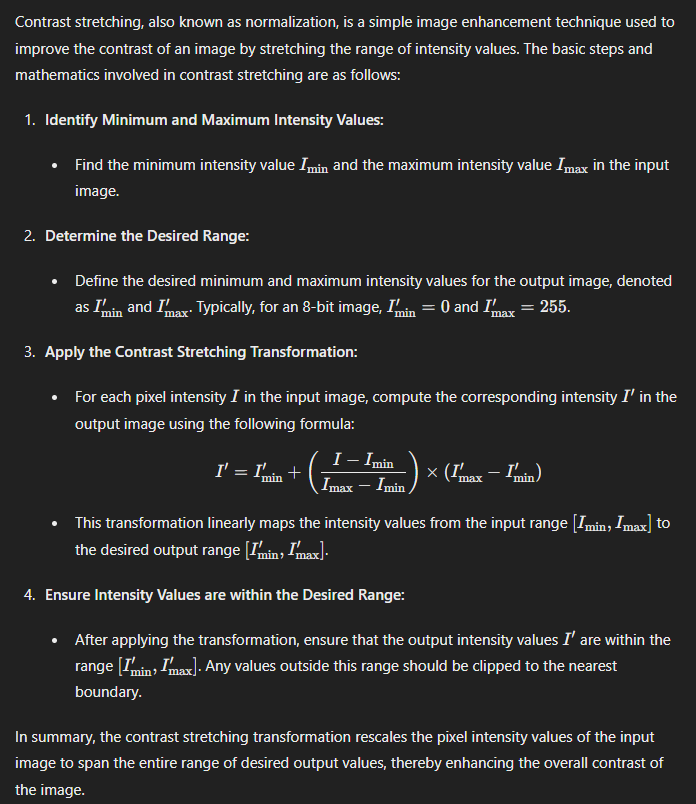

In [ ]:
def contrast_stretching_channel(image):
  # flatten the image
  flatten_image = image.flatten()

  # find minimum and maximum pixules in the image
  Imin = flatten_image.min()
  Imax = flatten_image.max()

  # apply the relation of the contrast adjusting
  new_flatten_image = (((flatten_image-Imin)/(Imax-Imin)) * (255 - 0)).round()

  new_flatten_image = new_flatten_image.astype(np.uint8)

  result_image = new_flatten_image.reshape(image.shape)
  return result_image

def contrast_image(image):
  # applying to gray images
  if len(image.shape) == 2:
    return contrast_stretching_channel(image)
  else:
    # splt /separate channels
    r_channel, g_channel, b_channel = cv2.split(image)

    # applying the contrast to each channel
    new_r_channel = contrast_stretching_channel(r_channel)
    new_g_channel = contrast_stretching_channel(g_channel)
    new_b_channel = contrast_stretching_channel(b_channel)

    # merge channels
    result_image = cv2.merge([new_r_channel, new_g_channel, new_b_channel])
  return result_image

### Retinex

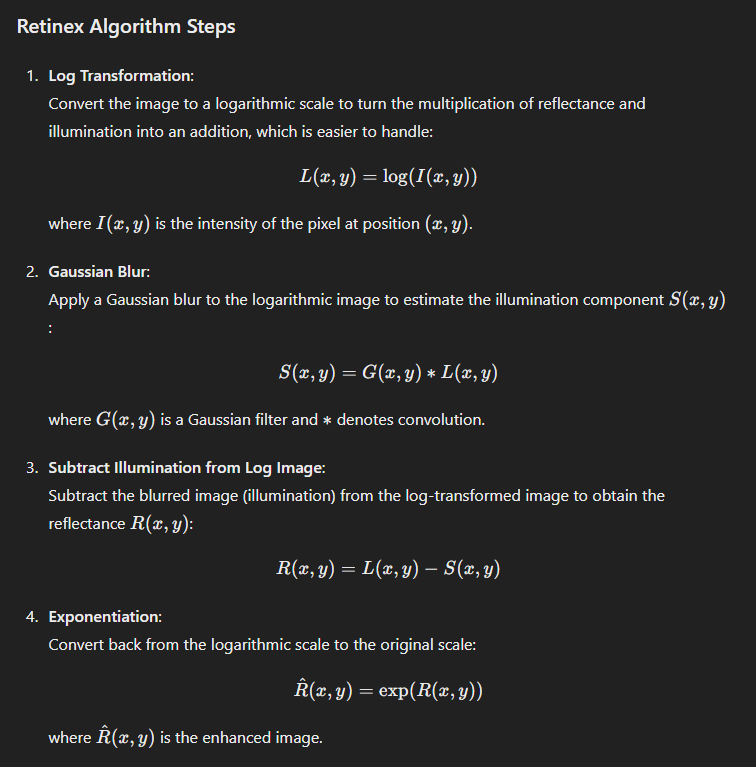

In [ ]:
import numpy as np
from scipy.ndimage import convolve

def retinex_channel(image):
    # Ensure the image has values > 0 to avoid issues with log(0)
    image = np.clip(image, 1e-6, None)

    # Define the Gaussian kernel (3x3) and normalize it
    kernel_3x3 = np.array([[1, 2, 1],
                           [2, 4, 2],
                           [1, 2, 1]]) / 16

    # Apply log transformation
    log_image = np.log(image)

    # Apply the Gaussian blur using convolution
    convolved_image = convolve(log_image, kernel_3x3, mode='reflect')

    # Subtract the blurred image (illumination estimate) from the log-transformed image
    reflectance = log_image - convolved_image

    # Convert back from the logarithmic scale to the original scale
    enhanced_image = np.exp(reflectance)

    # Convert the result back to uint8, scaling properly
    enhanced_image = np.clip(enhanced_image * 255, 0, 255).astype(np.uint8)

    return enhanced_image

def retinex(image):
  # applying to gray images
  if len(image.shape) == 2:
    return retinex_channel(image)
  else:
    # splt /separate channels
    r_channel, g_channel, b_channel = cv2.split(image)

    # applying the contrast to each channel
    new_r_channel = retinex_channel(r_channel)
    new_g_channel = retinex_channel(g_channel)
    new_b_channel = retinex_channel(b_channel)

    # merge channels
    result_image = cv2.merge([new_r_channel, new_g_channel, new_b_channel])
  return result_image